In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix
from scipy.stats import spearmanr as spearman
from itertools import combinations as combs
from factslab.datastructures import ConstituencyTree, DependencyTree

pilot_file = "new_pilot_protocol2/Batch_3318370_batch_results.csv"
pilot_file_old_v = "Batch_3220834_batch_results.csv"
sid_pilot_file = "Batch_193054_batch_results_sid.csv"
ud_trees = '/Users/sidvash/facts_lab/UD_data_trees/structures.tsv'
#sid_pilot_file = "Batch_193054_batch_results_sid.csv"

pd.options.mode.chained_assignment = None 

## Sentence Mappings

In [2]:
struct_dict = {}

with open(ud_trees, 'r') as f:
    structs_sents = [line.strip().split('\t') for line in f]

for sent_id, tree_list, sent in structs_sents:
    struct_dict[sent_id] = DependencyTree.fromstring(tree_list)
    struct_dict[sent_id].sentence = sent.split(" ")

## New Pilot Data

In [3]:
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]

#data.head()

In [4]:
def extract_dataframe_new(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples(): #Row for each HIT
        for idx, local_dict in enumerate(row.dicts):  #idxs for each Question in the HIT
            temp_dict = local_dict.copy()
            len_pred1 = len(temp_dict['pred1'].split(","))
            len_pred2 = len(temp_dict['pred2'].split(","))
            var_conf = "Answer_confidence_range" + str(idx+1)
                
            lst_pred1_sliders = []
            for i in range(len_pred1):
                var_pred1 = "Answer_sld_pred1_" + str(idx+1) + "_" + str(i)
                lst_pred1_sliders.append(getattr(row, var_pred1))
                
            temp_dict["pred1_sliders"] = lst_pred1_sliders
            
            lst_pred2_sliders = []
            for i in range(len_pred2):
                var_pred2 = "Answer_sld_pred2_" + str(idx+1) + "_" + str(i)
                lst_pred2_sliders.append(getattr(row, var_pred2))
                
            temp_dict["pred2_sliders"] = lst_pred2_sliders
            temp_dict["confidence"] = getattr(row, var_conf)
            temp_dict["worker_id"] = row.WorkerId
            temp_dict["hit_id"] = row.HITId

            global_list.append(temp_dict)
        
    return pd.DataFrame(global_list)

def extract_dataframe_old(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_pred1 = "Answer_sld_pred1_" + str(idx+1)
            var_pred2 =  "Answer_sld_pred2_" + str(idx+1)
            var_conf = "Answer_confidence_range" + str(idx+1)
            
            temp_dict["slider1_posn"] = getattr(row, var_pred1)
            temp_dict["slider2_posn"] = getattr(row, var_pred2)
            temp_dict["confidence"] = getattr(row, var_conf)
            temp_dict["worker_id"] = row.WorkerId
            temp_dict["hit_id"] = row.HITId

            global_list.append(temp_dict)
            
    return pd.DataFrame(global_list)

def extract_sentence(row, sent_id):
    sid, num = getattr(row, sent_id).split(" ")
    sent = sid + " sent_" + num
    return len(struct_dict[sent].sentence)

In [5]:
pilot_data_new = extract_dataframe_new(data)
pilot_data_new["split"] = pilot_data_new.sentence_id_1.map(lambda x: x.split(".")[0].split("-")[-1])
pilot_data_new = pilot_data_new[pilot_data_new.columns[::-1]]
print(pilot_data_new.shape)
pilot_data_new.head()

(490, 16)


,split,worker_id,sentence_id_2,sentence_id_1,sentence,pred_token2,pred_token1,pred_root_token2,pred_root_token1,pred2_sliders,pred2,pred1_sliders,pred1,id,hit_id,confidence
0,train,A2VNR6984SDFGQ,en-ud-train.conllu 6782,en-ud-train.conllu 6781,"The CURSE OF GOD <span class=\""predicate1\"">...","1_2,4,8,12_20_21_22_23","4,9","2,4,8,22","4,9","[47 - 65, 45 - 65, 28 - 39, 0 - 15]","is interesting,notice,shot,being the holy numb...","[4 - 25, 27 - 40]","carried,shot",1,3E22YV8GG2J5V93ZEJFDZSPHGEMNP1,3.0
1,train,A2VNR6984SDFGQ,en-ud-train.conllu 12378,en-ud-train.conllu 12377,"If you <span class=\""predicate1\""><sup>1</su...",3,"2,7,11,14,17,23,27,31,37,39,42,48,52,58_59_60_61",3,"2,7,11,14,17,23,27,31,37,39,42,48,52,60",[58 - 77],learn,"[5 - 26, 7 - 25, 9 - 21, 22 - 25, 26 - 29, 28 ...","want,lie,say,operate,change,know,talking,recom...",2,3E22YV8GG2J5V93ZEJFDZSPHGEMNP1,2.0
2,train,A2VNR6984SDFGQ,en-ud-train.conllu 868,en-ud-train.conllu 867,An editorial in the church - owned Deseret Mor...,_null_,"17,36,49,63,65",_null_,"17,36,49,63,65",[nan],_null_,"[12 - 37, 20 - 34, 23 - 33, 33 - 49, 35 - 51]","acknowledged,stir,contributed,taken,dealing",3,3E22YV8GG2J5V93ZEJFDZSPHGEMNP1,2.0
3,train,A2VNR6984SDFGQ,en-ud-train.conllu 1093,en-ud-train.conllu 1092,"I do <span class=\""predicate1\""><sup>1</sup>...","4,12,14,16,25,26_27_28,33,37,45","2,10,20,22","4,12,14,16,25,28,33,37,45","2,10,20,22","[40 - 65, 50 - 69, 57 - 79, 63 - 77, 67 - 79, ...","subscribe,watch,listen,have,think,is patently ...","[7 - 28, 13 - 31, 21 - 31, 35 - 50]","get,haul,made,do",4,3E22YV8GG2J5V93ZEJFDZSPHGEMNP1,2.0
4,train,ACPPFTEDFO6Q7,en-ud-train.conllu 6782,en-ud-train.conllu 6781,"The CURSE OF GOD <span class=\""predicate1\"">...","1_2,4,8,12_20_21_22_23","4,9","2,4,8,22","4,9","[66 - 98, 66 - 76, 66 - 72, 72 - 98]","is interesting,notice,shot,being the holy numb...","[10 - 65, 70 - 72]","carried,shot",1,3E22YV8GG2J5V93ZEJFDZSPHGEMNP1,2.0


In [6]:
pilot_data_new.split.value_counts()

train    435
dev       55
Name: split, dtype: int64

## Transform data into two-predicates form

In [7]:
data_dict = {}
row_index = 0
for row in pilot_data_new.itertuples():
    lst1_tokens = lst1_preds = lst1_sliders = lst2_tokens = lst2_preds = lst2_sliders = []
    ## Store pred_tokens and preds from Sentence 1
    if row.pred_root_token1 != "_null_":
        lst1_tokens = row.pred_root_token1.split(",")
        lst1_preds = row.pred1.split(",")
        lst1_sliders = row.pred1_sliders
    ## Store pred_tokens and preds from Sentence 2
    if row.pred_root_token2 != "_null_":
        lst2_tokens = row.pred_root_token2.split(",")
        lst2_preds = row.pred2.split(",")
        lst2_sliders = row.pred2_sliders
        
    cnt_1, cnt_2 = len(lst1_tokens), len(lst2_tokens) 
    
    ## Combine tokens and preds from both sentences
    all_tokens = lst1_tokens + lst2_tokens
    total_len = len(all_tokens)
    all_preds = lst1_preds + lst2_preds
    all_sliders = lst1_sliders + lst2_sliders
    
    
    #Find combinations of 2 at a time
    combin_idxs = combs(range(total_len), 2)
    #Create a row for every combination
    for idx1, idx2 in combin_idxs:
        curr_cols= []
        
        curr_cols.append(row.split)  #split
        curr_cols.append(row.worker_id) #worker
        
        if idx1< cnt_1 and idx2 < cnt_1:
            curr_cols.append(row.sentence_id_1) #sid 1
            curr_cols.append(row.sentence_id_1) #sid 2
            sent_token = row.sentence_id_1 + "_" + str(all_tokens[idx1]) + "_" + str(all_tokens[idx2])
            
        elif idx1 >= cnt_1 and idx2 >= cnt_1:
            curr_cols.append(row.sentence_id_2) #sid 1
            curr_cols.append(row.sentence_id_2) #sid 2
            sent_token = row.sentence_id_1 + "_" + str(all_tokens[idx1]) + "_" + str(all_tokens[idx2])
            
        else:
            curr_cols.append(row.sentence_id_1) #sid 1
            curr_cols.append(row.sentence_id_2) #sid 2
            sent_token = row.sentence_id_1 + "_" + str(all_tokens[idx1]) +"_" + \
                                                    row.sentence_id_2 + "_" + str(all_tokens[idx2])
            
        curr_cols.append(sent_token) #sent_token
        curr_cols.append(all_preds[idx1]) #pred1
        curr_cols.append(all_preds[idx2]) #pred2
        curr_cols.append(all_sliders[idx1]) #slider1_posn
        curr_cols.append(all_sliders[idx2]) #slider2_posn
        
        
        #pred_token
        data_dict[row_index] = curr_cols
        row_index+=1
        

In [8]:
cols = ['split', 'worker_id', 'sentence_id_1', 'sentence_id_2', "sent_token", "pred1", "pred2", "slider1", "slider2"]
pilot_data_p2 = pd.DataFrame.from_dict(data_dict, orient='index', columns = cols)
pilot_data_p2.head()

,split,worker_id,sentence_id_1,sentence_id_2,sent_token,pred1,pred2,slider1,slider2
0,train,A2VNR6984SDFGQ,en-ud-train.conllu 6781,en-ud-train.conllu 6781,en-ud-train.conllu 6781_4_9,carried,shot,4 - 25,27 - 40
1,train,A2VNR6984SDFGQ,en-ud-train.conllu 6781,en-ud-train.conllu 6782,en-ud-train.conllu 6781_4_en-ud-train.conllu 6...,carried,is interesting,4 - 25,47 - 65
2,train,A2VNR6984SDFGQ,en-ud-train.conllu 6781,en-ud-train.conllu 6782,en-ud-train.conllu 6781_4_en-ud-train.conllu 6...,carried,notice,4 - 25,45 - 65
3,train,A2VNR6984SDFGQ,en-ud-train.conllu 6781,en-ud-train.conllu 6782,en-ud-train.conllu 6781_4_en-ud-train.conllu 6...,carried,shot,4 - 25,28 - 39
4,train,A2VNR6984SDFGQ,en-ud-train.conllu 6781,en-ud-train.conllu 6782,en-ud-train.conllu 6781_4_en-ud-train.conllu 6...,carried,being the holy numbers in,4 - 25,0 - 15


In [9]:
pilot_data_p2.shape

(12850, 9)

### Extract sent_tokens from older version

In [10]:
data = pd.read_csv(pilot_file_old_v)
data.columns = [c.replace('.', '_') for c in data.columns]

pilot_data_old = extract_dataframe_old(data)

#Re-arrange the order 
cols = list(pilot_data_old.columns)
#pilot_data_old = pilot_data_old[pilot_data_old.columns[::-1]].drop('sentence', axis=1)
pilot_data_old = pilot_data_old[pilot_data_old.columns[::-1]]


#Drop start, end, instant variables that were stored in the json data
pilot_data_old = pilot_data_old.drop(['start_pred1', 'start_pred2', 'end_pred1', 'end_pred2',
                             'instant_pred1', 'instant_pred2'], axis=1)


#pilot_data_old.replace('na',np.NaN, inplace=True)
pilot_data_old['sent_token'] = pilot_data_old['sentence_id'] + "_" +\
                            pilot_data_old['pred_token1'].map(lambda x: str(x)) + "_" +\
                             pilot_data_old['pred_token2'].map(lambda x: str(x))
pilot_data_old.head()

,worker_id,slider2_posn,slider1_posn,sentence_id,sentence,pred_token2,pred_token1,pred2,pred1,id,hit_id,confidence,sent_token
0,AURYD2FH3FUOQ,27 - 46,39 - 46,en-ud-train.conllu 13,"On Wednesday guerrillas had <span class=\""pre...",16,4,way,kidnapped,1,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,3,en-ud-train.conllu 13_4_16
1,AURYD2FH3FUOQ,6 - 17,25 - 41,en-ud-train.conllu 46,Yesterday there were tens of them <span class...,26,6,leave,putting,2,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,1,en-ud-train.conllu 46_6_26
2,AURYD2FH3FUOQ,19 - 26,35 - 37,en-ud-train.conllu 60,"He did once <span class=\""predicate\""> make</...",14,3,shooting,make,3,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,0,en-ud-train.conllu 60_3_14
3,AURYD2FH3FUOQ,57 - 80,35 - 36,en-ud-train.conllu 65,"He <span class=\""predicate\""> added</span> t...",57,1,dragged,added,4,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,2,en-ud-train.conllu 65_1_57
4,AURYD2FH3FUOQ,15 - 16,10 - 16,en-ud-train.conllu 118,"As a child in the 50&#39;s I <span class=\""pr...",34,7,started,had,5,3MQY1YVHS3P8GHXKJ4IHY2G1UY12BZ,2,en-ud-train.conllu 118_7_34


In [11]:
sent_token_set = set(pilot_data_old.sent_token.values)

## New dataset with same sent_tokens as older version

In [12]:
pilot_data_p2_mod = pilot_data_p2.loc[pilot_data_p2['sent_token'].isin(sent_token_set)]
print(pilot_data_p2_mod.shape)
pilot_data_p2_mod.index = range(len(pilot_data_p2_mod.index))
pilot_data_p2_mod.head()

(475, 9)


,split,worker_id,sentence_id_1,sentence_id_2,sent_token,pred1,pred2,slider1,slider2
0,train,A2VNR6984SDFGQ,en-ud-train.conllu 6781,en-ud-train.conllu 6781,en-ud-train.conllu 6781_4_9,carried,shot,4 - 25,27 - 40
1,train,A2VNR6984SDFGQ,en-ud-train.conllu 12377,en-ud-train.conllu 12377,en-ud-train.conllu 12377_37_42,says,need,35 - 55,44 - 65
2,train,A2VNR6984SDFGQ,en-ud-train.conllu 867,en-ud-train.conllu 867,en-ud-train.conllu 867_17_49,acknowledged,contributed,12 - 37,23 - 33
3,train,A2VNR6984SDFGQ,en-ud-train.conllu 1092,en-ud-train.conllu 1092,en-ud-train.conllu 1092_2_10,get,haul,7 - 28,13 - 31
4,train,ACPPFTEDFO6Q7,en-ud-train.conllu 6781,en-ud-train.conllu 6781,en-ud-train.conllu 6781_4_9,carried,shot,10 - 65,70 - 72


## Analysis

In [13]:
def time_ml_tag(row, var1, var2):
    '''
    Creates time ML tags from slider positions of two events 
    
    Eg: EVENT 1 "is before" EVENT2
    
    Eg: Relatins: is before
    '''
    ans = ""
    
    slider1 = getattr(row, var1)
    slider2 = getattr(row, var2)
    
    event1 = [int(x) for x in slider1.split("-")]
    event2 = [int(x) for x in slider2.split("-")]
    
    if (event1[0] == event2[0]) and (event1[1] == event2[1]):
        ans = "simultaneous"
        
    elif event1[1] <= event2[0]:
        ans = "before"
    
    elif event1[0] >= event2[1]:
        ans = "after"
        
    elif event1[1] >= event2[1] and event1[0] <= event2[0]:
        ans = "includes"
        
    elif event1[1] <= event2[1] and event1[0] >= event2[0]:
        ans = "is_included"
    
    elif event1[0] < event2[0] and event1[1] > event2[0]:
        ans = "before_cont"
        
    elif event1[0] < event2[1] and event1[1] > event2[1]:
        ans = "after_cont"
    
    else: 
        ans = "other"
    
    return ans

In [14]:
pilot_data_p2_mod['timeML_tag'] = pilot_data_p2_mod.apply(lambda row: time_ml_tag(row, 'slider1', 'slider2'), axis=1)

In [15]:
pilot_data_p2_mod.head()

,split,worker_id,sentence_id_1,sentence_id_2,sent_token,pred1,pred2,slider1,slider2,timeML_tag
0,train,A2VNR6984SDFGQ,en-ud-train.conllu 6781,en-ud-train.conllu 6781,en-ud-train.conllu 6781_4_9,carried,shot,4 - 25,27 - 40,before
1,train,A2VNR6984SDFGQ,en-ud-train.conllu 12377,en-ud-train.conllu 12377,en-ud-train.conllu 12377_37_42,says,need,35 - 55,44 - 65,before_cont
2,train,A2VNR6984SDFGQ,en-ud-train.conllu 867,en-ud-train.conllu 867,en-ud-train.conllu 867_17_49,acknowledged,contributed,12 - 37,23 - 33,includes
3,train,A2VNR6984SDFGQ,en-ud-train.conllu 1092,en-ud-train.conllu 1092,en-ud-train.conllu 1092_2_10,get,haul,7 - 28,13 - 31,before_cont
4,train,ACPPFTEDFO6Q7,en-ud-train.conllu 6781,en-ud-train.conllu 6781,en-ud-train.conllu 6781_4_9,carried,shot,10 - 65,70 - 72,before


includes        119
before           94
is_included      83
before_cont      73
after_cont       43
after            34
simultaneous     29
Name: timeML_tag, dtype: int64


/Users/sidvash/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


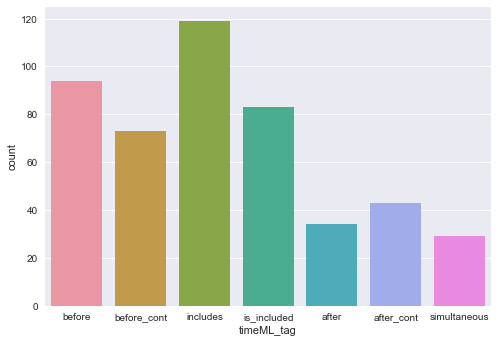

In [16]:
print(pilot_data_p2_mod.timeML_tag.value_counts())
sns.countplot(x='timeML_tag', data=pilot_data_p2_mod)
plt.show()


In [17]:
pilot_data = pilot_data_p2_mod

In [18]:
#sns.countplot(x='confidence', data=pilot_data)
#plt.show()


## Inter-Annotator Agreement

In [19]:
print("Number of annotators : {}".format(len(pilot_data.worker_id.unique())))

Number of annotators : 43


#### Raw Agreement

In [20]:
def calc_raw_agreement(data, key_var, check_var, degree=5):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    4. degree: Degree to which annotators agree: 
                5 means all annotators had the same answer
                4 means >=4 annotators had the same answer
                3 means >=3 annotators had the same answer
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(max(set(temp), key=temp.count)) >= degree:
                raw_count += 1
                keys.append(iden)

    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys



In [21]:
a1, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'timeML_tag', degree=5)
print("\n")
a2, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'timeML_tag', degree=4)
print("\n")
a3, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'timeML_tag', degree=3)
print("\n")
a4, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'timeML_tag', degree=2)

####### Raw Count for timeML_tag ###########
Total count of unique sent_token is 95
Raw count of matched for timeML_tag is 0
Inter-annotator agreement for timeML_tag is 0.0%




####### Raw Count for timeML_tag ###########
Total count of unique sent_token is 95
Raw count of matched for timeML_tag is 6
Inter-annotator agreement for timeML_tag is 6.315789473684211%




####### Raw Count for timeML_tag ###########
Total count of unique sent_token is 95
Raw count of matched for timeML_tag is 35
Inter-annotator agreement for timeML_tag is 36.84210526315789%




####### Raw Count for timeML_tag ###########
Total count of unique sent_token is 95
Raw count of matched for timeML_tag is 88
Inter-annotator agreement for timeML_tag is 92.63157894736842%




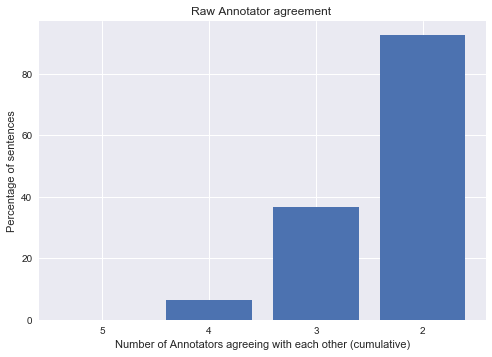

In [22]:
agrees = [a1, a2, a3, a4]
degree = ['5', '4', '3', '2']

plt.bar(degree, agrees)
plt.xlabel("Number of Annotators agreeing with each other (cumulative)")
plt.ylabel("Percentage of sentences")
plt.title("Raw Annotator agreement ")
plt.show()

### Kappa estimation 

In [23]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def extract_worker_pair_dict(data, worker_pairs, worker_dict, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    ans = {}
    
    for (w1, w2) in worker_pairs:
        common_set = worker_dict[w1].intersection(worker_dict[w2])
        if common_set != set():
            ans[(w1,w2)] = list(common_set)
        
    return ans

In [24]:
worker_pairs = extract_pairs_of_workers(pilot_data, 'worker_id')
worker_dict = extract_worker_sent_dict(pilot_data, 'worker_id', 'sent_token')
worker_pair_dict = extract_worker_pair_dict(pilot_data, worker_pairs, worker_dict,'sent_token')

In [25]:
def average_metric_sklearn(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    kappas = []
    accuracies = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        
        for key in common_set:
            val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val4 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values 
            temp1.append(val3[0])
            temp2.append(val4[0])
                   
        if temp1 == [] or temp2 == []:
            continue

        elif temp1==temp2:
            kappas.append(1.0)
        else:
            kappas.append(kappa(temp1, temp2))
        accuracies.append(accuracy(temp1, temp2))
                
    return kappas, accuracies

In [26]:
kappas = {}
accuracies = {}
vars_temp = ['timeML_tag']
for var in vars_temp:
    kappas[var], accuracies[var] = average_metric_sklearn(pilot_data, 'worker_id', 'sent_token', var)
    print("{} -- Completed!".format(var))

timeML_tag -- Completed!


In [27]:
kappa_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kappas.items() ]))
acc_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in accuracies.items() ]))

In [28]:
print('Average Kappa for "timeML_tag" variable: {}'.format(np.mean(kappa_data['timeML_tag'])))
print("\n")

print('Average Accuracy for "timeML_tag" variable: {}'.format(np.mean(acc_data['timeML_tag'])))
print("\n")

Average Kappa for "timeML_tag" variable: 0.062423145261948726


Average Accuracy for "timeML_tag" variable: 0.21850453530985553




## Confusion Matrix

In [29]:
time_tags = list(pilot_data.timeML_tag.unique())

In [30]:
time_tags

['before',
 'before_cont',
 'includes',
 'is_included',
 'after',
 'after_cont',
 'simultaneous']

In [31]:
def average_confusion_matrix(data, worker_id, key_var, check_var, time_tags):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    conf_list = []
    conf_rev_list = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        
        for key in common_set:
            val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val4 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values 
            temp1.append(val3[0])
            temp2.append(val4[0])
                   
        if temp1 == [] or temp2 == []:
            continue

        conf_matrix = confusion_matrix(temp1, temp2, labels=time_tags)
        conf_matrix_rev = confusion_matrix(temp2, temp1, labels=time_tags)
        
        #NORMALISE
        sum_a = np.sum(conf_matrix,axis=None)
        sum_rev = np.sum(conf_matrix_rev,axis=None)
        
        #conf_matrix = conf_matrix/sum_a
        #conf_matrix_rev = conf_matrix_rev/sum_rev
        
        conf_list.append(conf_matrix)
        conf_rev_list.append(conf_matrix_rev)
        
                
    return conf_list, conf_rev_list

def matprint(mat, fmt="g"):
    '''
    Pretty print a numpy matrix
    
    Source: https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    '''
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [32]:
conf_list, conf_rev_list = average_confusion_matrix(pilot_data, 'worker_id', 'sent_token', 'timeML_tag', time_tags)

In [33]:
A = sum(conf_list) + sum(conf_list).T
B = sum(conf_rev_list) + sum(conf_rev_list).T

In [34]:
A = A/np.sum(A, axis=None)
B = B/np.sum(B, axis=None)
matprint(A)

 0.0547368   0.0357895  0.0431579   0.0384211  0.00421053   0.0163158  0.00526316  
 0.0357895   0.0252632  0.0336842   0.0294737  0.00736842   0.0126316  0.00947368  
 0.0431579   0.0336842  0.0673684        0.04   0.0173684   0.0273684   0.0215789  
 0.0384211   0.0294737       0.04   0.0305263        0.01   0.0184211  0.00789474  
0.00421053  0.00736842  0.0173684        0.01   0.0221053  0.00526316  0.00526316  
 0.0163158   0.0126316  0.0273684   0.0184211  0.00526316  0.00631579  0.00421053  
0.00526316  0.00947368  0.0215789  0.00789474  0.00526316  0.00421053  0.00736842  


In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




Confusion matrix, without normalization
[[ 0.05473684  0.03578947  0.04315789  0.03842105  0.00421053  0.01631579
   0.00526316]
 [ 0.03578947  0.02526316  0.03368421  0.02947368  0.00736842  0.01263158
   0.00947368]
 [ 0.04315789  0.03368421  0.06736842  0.04        0.01736842  0.02736842
   0.02157895]
 [ 0.03842105  0.02947368  0.04        0.03052632  0.01        0.01842105
   0.00789474]
 [ 0.00421053  0.00736842  0.01736842  0.01        0.02210526  0.00526316
   0.00526316]
 [ 0.01631579  0.01263158  0.02736842  0.01842105  0.00526316  0.00631579
   0.00421053]
 [ 0.00526316  0.00947368  0.02157895  0.00789474  0.00526316  0.00421053
   0.00736842]]


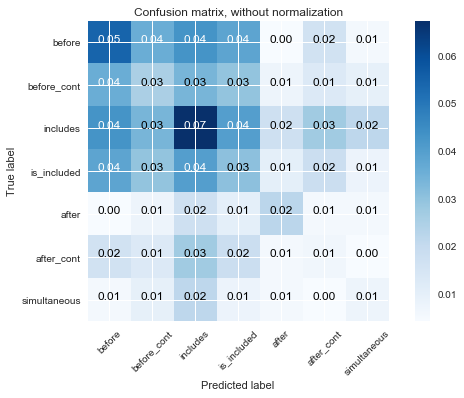

In [36]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(A, classes=time_tags, normalize=False,
                      title='Confusion matrix, without normalization')

plt.show()

Confusion matrix, without normalization
[[ 0.05473684  0.03578947  0.04315789  0.03842105  0.00421053  0.01631579
   0.00526316]
 [ 0.03578947  0.02526316  0.03368421  0.02947368  0.00736842  0.01263158
   0.00947368]
 [ 0.04315789  0.03368421  0.06736842  0.04        0.01736842  0.02736842
   0.02157895]
 [ 0.03842105  0.02947368  0.04        0.03052632  0.01        0.01842105
   0.00789474]
 [ 0.00421053  0.00736842  0.01736842  0.01        0.02210526  0.00526316
   0.00526316]
 [ 0.01631579  0.01263158  0.02736842  0.01842105  0.00526316  0.00631579
   0.00421053]
 [ 0.00526316  0.00947368  0.02157895  0.00789474  0.00526316  0.00421053
   0.00736842]]


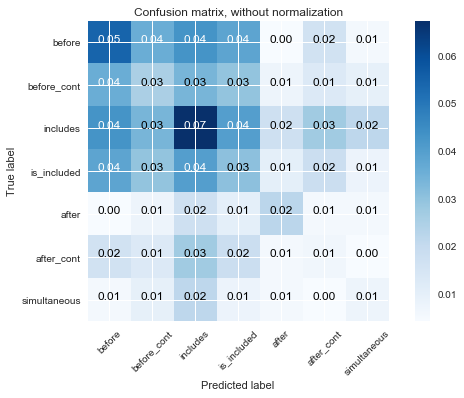

In [37]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(B, classes=time_tags, normalize=False,
                      title='Confusion matrix, without normalization')

plt.show()

#### Sid's predictions

In [38]:
sid_data = pd.read_csv(sid_pilot_file)
sid_data.columns = [c.replace('.', '_') for c in sid_data.columns]

sid_pilot_data = extract_dataframe_old(sid_data)

#Re-arrange the order 
cols = list(sid_pilot_data.columns)
#sid_pilot_data = sid_pilot_data[sid_pilot_data.columns[::-1]].drop('sentence', axis=1)
sid_pilot_data = sid_pilot_data[sid_pilot_data.columns[::-1]]


#Drop start, end, instant variables that were stored in the json data
sid_pilot_data = sid_pilot_data.drop(['start_pred1', 'start_pred2', 'end_pred1', 'end_pred2',
                             'instant_pred1', 'instant_pred2'], axis=1)


#pilot_data.replace('na',np.NaN, inplace=True)
sid_pilot_data['sent_token'] = sid_pilot_data['sentence_id'] + "_" +\
                            sid_pilot_data['pred_token1'].map(lambda x: str(x)) + "_" +\
                             sid_pilot_data['pred_token2'].map(lambda x: str(x))
sid_pilot_data.head()

,worker_id,slider2_posn,slider1_posn,sentence_id,sentence,pred_token2,pred_token1,pred2,pred1,id,hit_id,confidence,sent_token
0,A2GL712W3LDMFO,32 - 73,45 - 60,en-ud-train.conllu 13,"On Wednesday guerrillas had <span class=\""pre...",16,4,way,kidnapped,1,35A1YQPVFEGOK6YXHVHV03G0I0CI51,4,en-ud-train.conllu 13_4_16
1,A2GL712W3LDMFO,22 - 43,52 - 100,en-ud-train.conllu 46,Yesterday there were tens of them <span class...,26,6,leave,putting,2,35A1YQPVFEGOK6YXHVHV03G0I0CI51,1,en-ud-train.conllu 46_6_26
2,A2GL712W3LDMFO,20 - 34,42 - 46,en-ud-train.conllu 60,"He did once <span class=\""predicate\""> make</...",14,3,shooting,make,3,35A1YQPVFEGOK6YXHVHV03G0I0CI51,2,en-ud-train.conllu 60_3_14
3,A2GL712W3LDMFO,44 - 51,28 - 34,en-ud-train.conllu 65,"He <span class=\""predicate\""> added</span> t...",57,1,dragged,added,4,35A1YQPVFEGOK6YXHVHV03G0I0CI51,2,en-ud-train.conllu 65_1_57
4,A2GL712W3LDMFO,41 - 47,13 - 41,en-ud-train.conllu 118,"As a child in the 50&#39;s I <span class=\""pr...",34,7,started,had,5,35A1YQPVFEGOK6YXHVHV03G0I0CI51,2,en-ud-train.conllu 118_7_34


before          36
after           21
simultaneous    13
includes         5
is_included      5
Name: timeML_tag, dtype: int64


/Users/sidvash/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


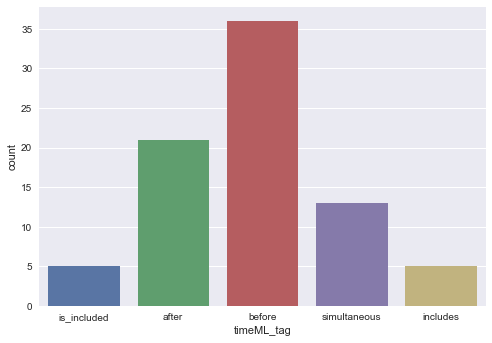

In [39]:
sid_pilot_data['timeML_tag'] = sid_pilot_data.apply(lambda row: time_ml_tag(row, 'slider1_posn', 'slider2_posn'), axis=1)
print(sid_pilot_data.timeML_tag.value_counts())
sns.countplot(x='timeML_tag', data=sid_pilot_data)
plt.show()

/Users/sidvash/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


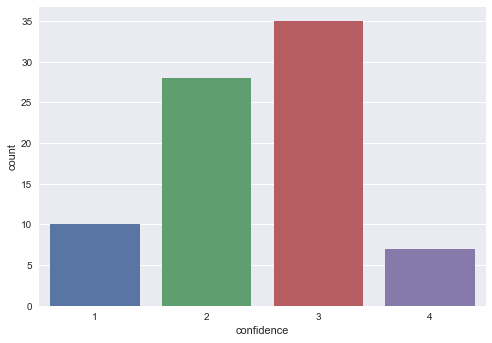

In [40]:
sns.countplot(x='confidence', data=sid_pilot_data)
plt.show()

### Manual Analysis of Sentences

In [41]:
#sid_pilot_data[sid_pilot_data.confidence==3]

In [42]:
#pilot_data[pilot_data.sent_token == "en-ud-train.conllu 11663_17_28"]

#### Examples with high confidence as per Sid:
 -  '&lsqb; an error  <span class=\\"predicate\\"> ** occurred **</span>  while  <span class=\\"predicate\\"> ** processing **</span>  this directive &rsqb;'

    my tag: is_included, 3/5 match , others - before, after
    
    
- 'Meanwhile , President George W Bush has  <span class=\\"predicate\\"> ** said **</span>  he will lead an inquiry into how the disaster was  <span class=\\"predicate\\"> ** handled **</span>  .'

    my tag: after, 3/5 match , others - is_included, before
    
    
- 'We then called the office and the man we spoke to  <span class=\\"predicate\\">** said **</span>  he &#39;d send someone out to look at it but could n&#39;t promise when - two weeks came and went and we  <span class=\\"predicate\\">** heard **</span>  nothing .'

    my tag: before, 5/5 match
    
   
- 'Well last night while I was  <span class=\\"predicate\\">** sleeping **</span>  , my hamster  <span class=\\"predicate\\">** escaped **</span>  from his cage .'

    my tag: includes, 3/5 match, others - before(4,2)
    
    
-  'Phone calls were n&#39;t returned when promised and the botched repair  <span class=\\"predicate\\"> ** took **</span>  a week longer than  <span class=\\"predicate\\">** promised **</span>  .'
    
      my tag: after, 5/5 match

#### Intriguing examples

- 'Right now , while we &#39;re  <span class=\\"predicate\\">** sitting **</span>  at our computers enjoying the internet , those innocent , beautiful , loving cats , are  <span class=\\"predicate\\">** dying **</span>  , somewhere in this troubled world a slow , agonizing death .'

    my tag - simultaneous, 2/5 match: others: (before-2 conf, after-2 conf, includes-3 conf)
    
    
- 'I did n&#39;t expect to react that way , but when I was  <span class=\\"predicate\\">** looking **</span>  around my workplace in Nashua , New Hampshire , and everyone else looked pretty much like me , it was really very  <span class=\\"predicate\\">** eerie **</span>  .'

    my tag - simultaneous, 0/5 match; others: (before:4/5 annotators, includes:1/5 with 4 confidence)
    
    
- 'Finally a chambermaid  <span class=\\"predicate\\">** stuck **</span>  her head around the corner from the top of the stairs and  <span class=\\"predicate\\">** told **</span>  us sternly that we could not be accommodated until 3 M , no exceptions .'

    my tag - before, 3/5 match; others-(simultaneous with 4 rating, includes with 3 rating)
    
    
- 'We typically only  <span class=\\"predicate\\">** book **</span>  deals when everything is  <span class=\\"predicate\\">** signed **</span>  off .'

    2/5 : before (4, 2 conf)
    2/5 : after (2, 1 conf)
    1/5: after_cont (3 conf)
    
    
- 'From a moral standpoint , you guys are really gon na take 2,000 bucks from someone that  <span class=\\"predicate\\">**  needs **</span>  that truck to work and support his family when you  <span class=\\"predicate\\">** know **</span>  it s just a piece of scrap metal ?'

    2/5: before (2,2 conf)
    1/5: simultaneous (2 conf)
    1/5: includes (2 conf)
    1/5: after_cont (3 conf)


### Agreement Dataset (at sentence level)

In [43]:
sent_tokens = list(pilot_data.sent_token.unique())

In [44]:
#Sent_token and sentence pairs
g = pilot_data.groupby(['sent_token' ,'sentence_id_1'])
sent_groups = dict(list(g.groups.keys()))

In [45]:
agree_data = pd.DataFrame(sent_tokens, columns = ['sent_token'])

In [46]:
def tag_counts(row, data, time_tag, sent_id):
    '''
    Count the number of a particular time_tag for a particular sentence id 
    as annotated by different annotators
    '''
    
    ans = list(data[data.sent_token == getattr(row, sent_id)]['timeML_tag'].values).count(time_tag)
    
    return ans

    

In [47]:
for tag in time_tags:
    agree_data[tag] = agree_data.apply(lambda row: tag_counts(row, pilot_data, tag, 'sent_token'), axis=1)

#### Left Join Sid's time_tags and sentences

In [48]:
temp_data = sid_pilot_data.rename(columns={"timeML_tag": "sid_tag"})
temp_data = temp_data[['sent_token', 'sid_tag']]
temp_data.head()

,sent_token,sid_tag
0,en-ud-train.conllu 13_4_16,is_included
1,en-ud-train.conllu 46_6_26,after
2,en-ud-train.conllu 60_3_14,after
3,en-ud-train.conllu 65_1_57,before
4,en-ud-train.conllu 118_7_34,before


In [49]:
agree_data = pd.merge(agree_data, temp_data, on = 'sent_token', how='left')
agree_data['sentence'] = agree_data.apply(lambda row: sent_groups[row.sent_token], axis=1)

In [50]:
agree_data['ann_agreement'] = agree_data.apply(lambda row: max(row.is_included, 
                                                         row.after, row.before, row.includes,
                                                         row.simultaneous, row.after_cont, row.before_cont), axis=1)
agree_data['mode_tag'] = agree_data[time_tags].idxmax(axis=1)

In [51]:
agree_data.head()

,sent_token,before,before_cont,includes,is_included,after,after_cont,simultaneous,sid_tag,sentence,ann_agreement,mode_tag
0,en-ud-train.conllu 6781_4_9,4,0,1,0,0,0,0,before,en-ud-train.conllu 6781,4,before
1,en-ud-train.conllu 12377_37_42,0,1,1,3,0,0,0,before,en-ud-train.conllu 12377,3,is_included
2,en-ud-train.conllu 867_17_49,0,1,1,3,0,0,0,after,en-ud-train.conllu 867,3,is_included
3,en-ud-train.conllu 1092_2_10,0,1,0,1,2,1,0,after,en-ud-train.conllu 1092,2,after
4,en-ud-train.conllu 11663_17_28,0,0,1,2,0,1,1,NaN,en-ud-train.conllu 11663,2,is_included


/Users/sidvash/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


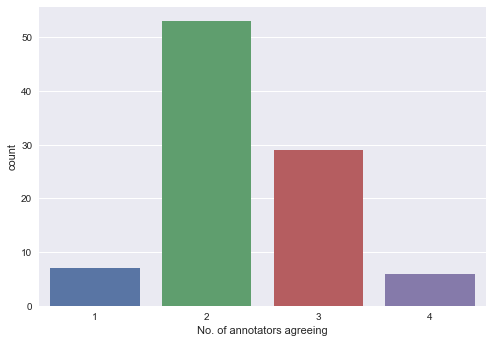

In [52]:
sns.countplot(x='ann_agreement', data=agree_data)
plt.xlabel("No. of annotators agreeing")
plt.show()

### Further Analysis of sentences

In [53]:
agree_data[agree_data.sid_tag == agree_data.mode_tag].shape

(28, 12)

The above number shows that 28/80 times sid's answer was matched by the majority-annotator answer

In [54]:
#agree_data.to_csv("agreement_data_protocol2.csv", index=False)

https://bit.ly/2spaJIz